# Homework09

Exercises to practice dimensionality reduction with PCA

## Goals

- Add unsupervised pre-processing to our ML flow: encode -> normalize -> pre-process -> train -> evaluate
- Build an intuition for PCA and when/how to use it
- Understand the benefits of dimensionality reduction

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/Homework07/raw/main/Homework07_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [2]:
import PIL.Image as PImage

from os import listdir, path

from data_utils import PCA, RandomForestClassifier

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same one we used in `Homework07`. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [3]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [5]:
# TODO: check and see what is inside the list here
print(train_files[:5])

['25-71.jpg', '07-85.jpg', '23-48.jpg', '13-21.jpg', '05-22.jpg']


Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [6]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [7]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print("Filenames:", train_files[:5])
print("Labels:   ", label_data[:5])

Filenames: ['25-71.jpg', '07-85.jpg', '23-48.jpg', '13-21.jpg', '05-22.jpg']
Labels:    [20, 5, 18, 11, 3]


Like in `Homework07`, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

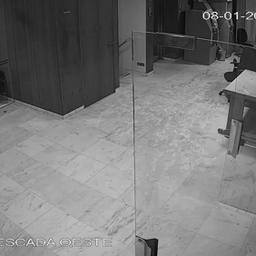

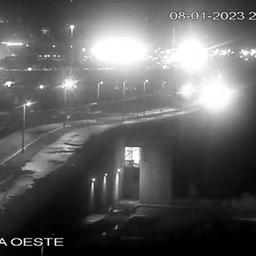

In [8]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did in Homewokr07 with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `Homework07`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [9]:
from data_utils import PCA
import pandas as pd

# TODO: run PCA, get DataFrame
NUM_COMPONENTS = 10  
pca = PCA(n_components=NUM_COMPONENTS)
pca_features = pca.fit_transform(pixel_data)

cam_pca_df = pd.DataFrame(pca_features)

# TODO: add "label" column
cam_pca_df["label"] = label_data

# TODO: print variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance preserved: {sum(pca.explained_variance_ratio_):.4f}")

# TODO: take a look at the first 5 rows
cam_pca_df.head()


Explained variance ratio: [0.24273758 0.14776564 0.12324789 0.08042213 0.05193327 0.03765846
 0.03234669 0.02826384 0.02169188 0.01918686]
Total variance preserved: 0.7853


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,label
0,7451.374243,-1877.593348,-795.202323,-3821.184036,977.828881,298.040450,1276.569976,-2640.193488,-1868.944112,569.086405,20
1,9183.670601,-6704.839146,2977.121954,-3625.201168,-2144.699307,273.862611,-3264.838235,5898.961228,1742.177712,-3264.832459,5
2,1391.607563,-6800.179814,-3192.015079,8885.918762,1715.605937,6303.912992,3743.200198,-1660.664447,-1584.995129,-2869.411792,18
3,-6438.538197,-10676.434948,-384.894060,705.871358,1206.699495,-4969.045466,5174.373411,708.252063,1777.656938,382.590036,11
4,2519.121101,8485.100293,-1981.854126,-2793.177597,-519.097896,-1241.846339,2344.012730,382.486187,1216.066094,-1241.134980,3


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:hotpink;">We kept 10 components.
This PCA transformation preserved 78.5% of the total variance, which means most of the important information in the original image data was retained.
Trying more components (e.g. 20 or 50) could help capture more detail, but 10 already gives a good balance between dimensionality reduction and information retention.</span>

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

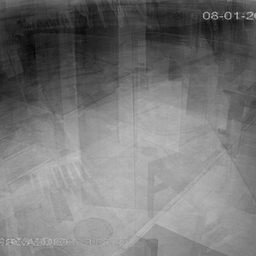

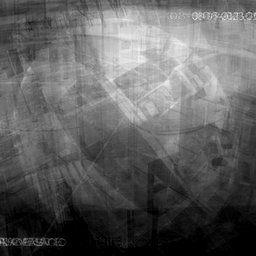

In [12]:
from IPython.display import display
from image_utils import make_image

# index 0
reconstructed_0 = pca.inverse_transform(pca_features.iloc[0])  
display(make_image(reconstructed_0, width=256))

# index 10
reconstructed_10 = pca.inverse_transform(pca_features.iloc[10])
display(make_image(reconstructed_10, width=256))


The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [13]:
# TODO: create a classifier
from data_utils import RandomForestClassifier

clf = RandomForestClassifier()

# TODO: split input and output features
X = cam_pca_df.drop(columns=["label"])  # input: PC0 ~ PC9
y = cam_pca_df["label"]                 # output: label

# TODO: fit the model
clf.fit(X, y)

# TODO: run predictions
train_predictions = clf.predict(X)


### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [14]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:hotpink;">High train accuracy means the model fits the training data well.
But test accuracy may be lower because the model hasn't seen that data before.
If there's overfitting, test performance can drop.</span>

### Run on Test set

Now we'll open the image files inside the `./data/image/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [15]:
from os import listdir

# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print("Number of test files:", len(test_files))
print("First few files:", test_files[:5])


Number of test files: 1573
First few files: ['8172462.jpg', '7752588.jpg', '11819482.jpg', '9268585.jpg', '10834611.jpg']


We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [16]:
test_pixel_data = []

for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [17]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one

test_pca_features = pca.transform(test_pixel_data)

import pandas as pd
test_pca_df = pd.DataFrame(test_pca_features)


It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

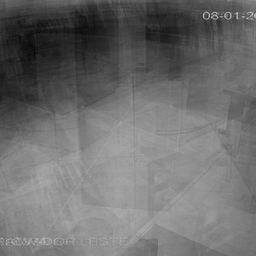

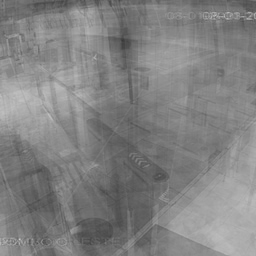

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,4411.443321,-2546.158277,208.437834,-2483.852202,115.294945,457.728847,789.992150,-3921.352163,-328.151199,555.883689
1,-4174.307014,2343.233159,8749.723627,322.847375,-1635.425921,2521.033535,583.363959,-4967.643916,840.519132,-406.653518
2,-6409.732235,-10626.663783,-392.214578,700.164076,1203.738435,-4952.856072,5158.383216,707.862608,1771.761757,382.947635
3,-47.849431,7171.140750,1938.314900,1171.791176,-1317.111510,350.222173,2392.025384,4302.941819,-752.175597,351.279551
4,1668.219517,3692.750779,4177.524726,-5070.629890,-2316.471199,1541.150184,4942.315272,430.176079,-746.915297,2819.695552


In [19]:
# TODO: reconstruct one or two images
from IPython.display import display
from image_utils import make_image

# index 0
reconstructed_test_0 = pca.inverse_transform(test_pca_df.iloc[0])
display(make_image(reconstructed_test_0, width=256))

# index 10
reconstructed_test_10 = pca.inverse_transform(test_pca_df.iloc[10])
display(make_image(reconstructed_test_10, width=256))


# TODO: take a look at the first 5 rows
test_pca_df.head()


### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:hotpink;">The reconstructed test images are noisier because the PCA was trained on the training data only.
The components were optimized to represent patterns in the train set, not the test set.
So, when we apply those same components to new images, some details are lost, causing blur and noise in reconstruction.</span>



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [20]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
test_predictions = clf.predict(test_pca_df)


# TODO: get accuracy
accuracy = CamUtils.classification_accuracy(test_files, test_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9230769230769231


### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to the classification model from <code>Homework07</code>? They can both be tuned to perform well, but how many features did we need last time in order to get an accuracy comparable to this?
</span>

<span style="color:hotpink;">The test accuracy is about 0.92, which is very high.
Even with just 10 PCA features, the model performs well.
In Homework07, we needed thousands of raw pixels to reach similar accuracy.
PCA allows efficient classification with fewer features.</span>